In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

rng = np.random.default_rng()

In [20]:
from mtt.sensor import Sensor
from mtt.simulator import Simulator
from mtt.data import OnlineDataset

init_simulator = lambda: Simulator(
    max_targets=10,
    p_initial=4,
    p_birth=2,
    p_survival=0.95,
    sigma_motion=0.1,
    sigma_initial_state=(3.0, 1.0, 1.0),
    max_distance=1e6,
)
init_sensor = lambda: Sensor(position=(1, 1), noise=(0.2, 0.1), p_detection=0.9)
dataset = OnlineDataset(n_steps=100, length=20, img_size=128, init_simulator=init_simulator, init_sensor=init_sensor)
dataset = list(dataset)

In [16]:
from mtt.models import Conv2dCoder
from torchinfo import summary

model = Conv2dCoder(n_channels=128, img_size=128, n_encoder=3, n_hidden=2, kernel_size=9, length=20)
summary(model, (1,) + model.input_shape)

torch.Size([1, 20, 128, 128])


Layer (type:depth-idx)                   Output Shape              Param #
Conv2dCoder                              --                        --
├─Sequential: 1-1                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 128, 64, 64]          207,488
│    └─ReLU: 2-2                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-3                       [1, 128, 32, 32]          1,327,232
│    └─ReLU: 2-4                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-5                       [1, 128, 16, 16]          1,327,232
│    └─ReLU: 2-6                         [1, 128, 16, 16]          --
├─Sequential: 1-2                        [128, 256]                --
│    └─Linear: 2-7                       [128, 256]                65,792
│    └─ReLU: 2-8                         [128, 256]                --
│    └─Linear: 2-9                       [128, 256]                65,792
│    └─ReLU: 2-10                        [128, 256]       

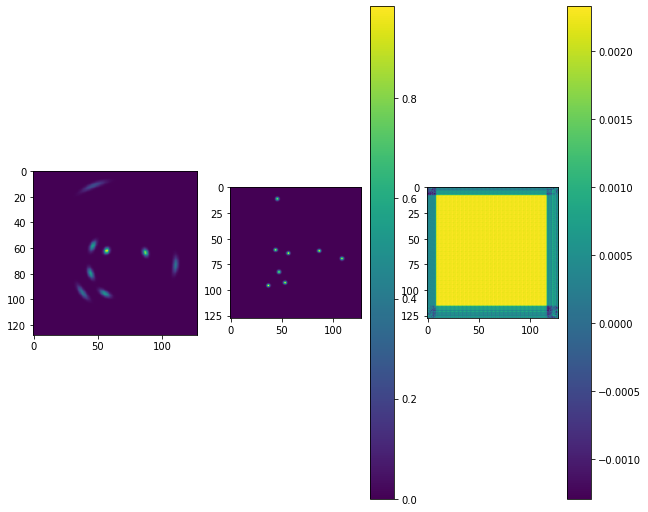

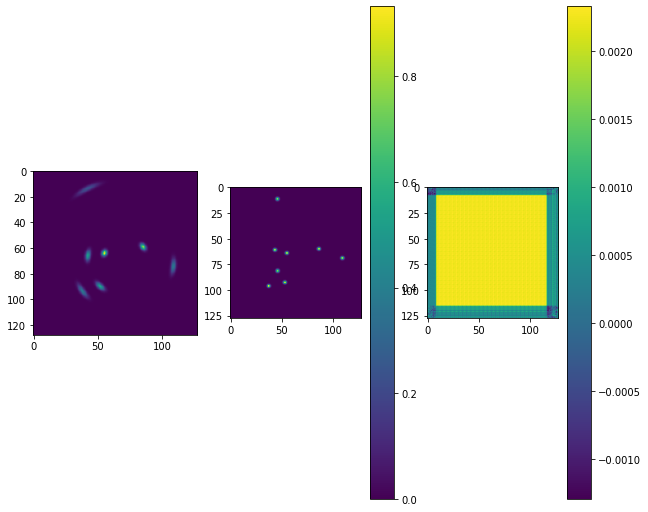

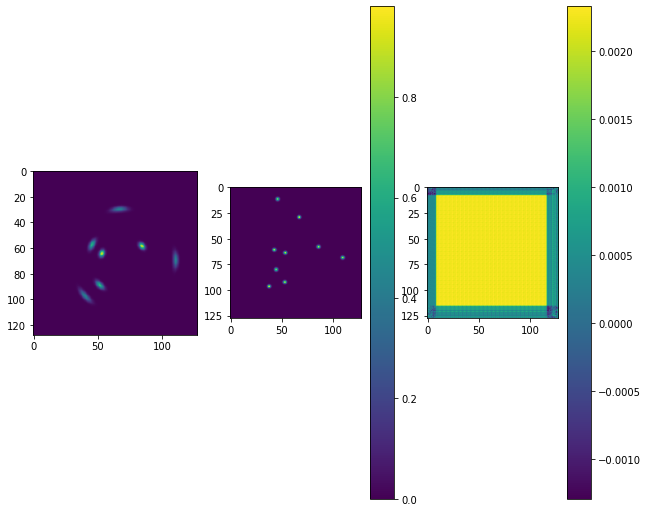

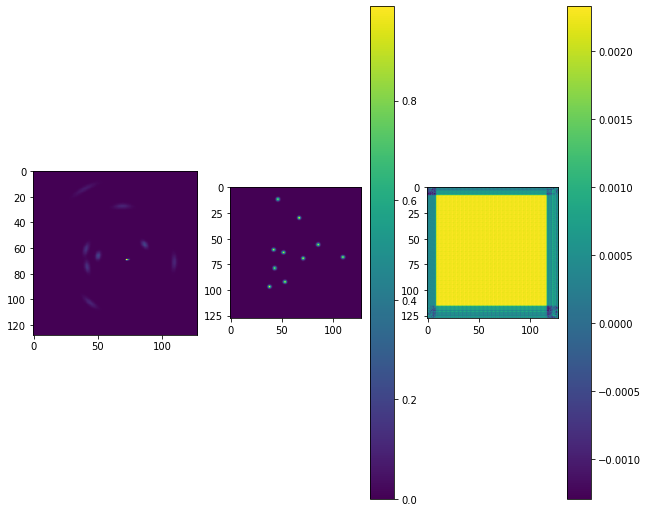

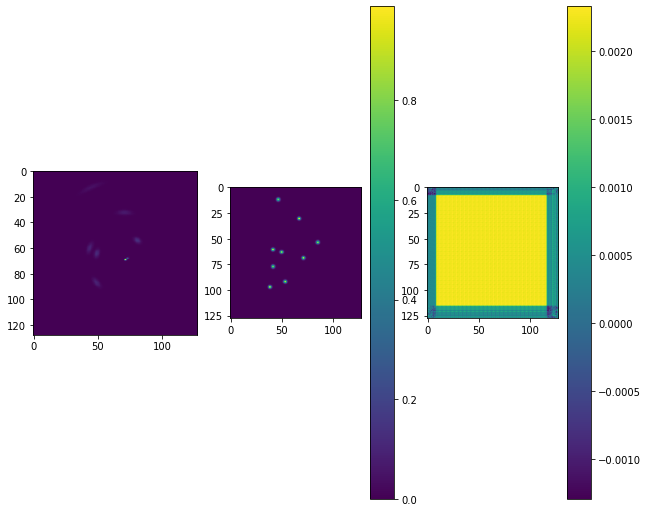

In [111]:
import guild.ipy as guild
import matplotlib.pyplot as plt
import numpy as np

run = guild.runs().iloc[0]
checkpoint = run.run.fmt["run_dir"] + "/checkpoints/last.ckpt"
model = Conv2dCoder.load_from_checkpoint(checkpoint)